In [2]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras

from scipy.stats import probplot
from scipy.stats import normaltest

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [3]:
import matplotlib as mpl
print(mpl.__version__)

3.2.1


In [14]:
inferenceLocations = ['undefined']
vibSamples = ['205','410','819','1638','3277']
vibSampleLabels = [r'$2^{11}$',r'$2^{12}$',r'$2^{13}$',r'$2^{14}$',r'$2^{15}$']
vibSampleLabels = ['2.05','4.10','8.19','16.4','32.8']

basePath = 'Edge-Device-Latency/'
modelId = 'RMS-Only'
deviceId = 'undefined'
numSamples = 900
numColumns = 2

latencyVals = np.zeros((numSamples,numColumns,len(vibSamples)))
columns = None

In [15]:
for i in range(len(vibSamples)):
    thisDF = pd.read_csv(basePath + deviceId +'_' + vibSamples[i] + '.csv')
    
    print(thisDF.values.shape)
    

    latencyVals[...,i] = thisDF.values[-numSamples:,:]



(900, 2)
(900, 2)
(900, 2)
(900, 2)
(900, 2)


mean latency, max latency, Max Score Difference, MSE

In [16]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

def box_plot(data,labels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,plot_type='box'):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()

    if plot_type == 'box':

        bp = plt.boxplot(data,
                        showfliers=showfliers,
                        patch_artist=True,
                        meanline=False,
                        notch=False,
                        medianprops={'color':'black',
                                     'linewidth':2},
                        whiskerprops={'linewidth':2},
                        capprops={'linewidth':2})
        ax = plt.gca()

        for patch, color in zip(bp['boxes'], thisColors):
            # change outline color
            patch.set(color=color, linewidth=2)
            patch.set_facecolor(color)
    else:
        violin_parts = plt.violinplot(data,
                  showmeans=False,
                  showmedians=False,
                  showextrema=False)
        ax = plt.gca()
        
        for pc in violin_parts['bodies']:
            pc.set_facecolor('red')
            pc.set_edgecolor('black')

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    


def box_plot_compare(data,labels,dataLabels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    position = [i+1 for i in range(data.shape[1])]
    tickPositions = []
    phantomLines = []
        
    for i in range(data.shape[-1]):
        
        max_index = data.shape[0] - max_cutoff
        min_index = min_cutoff
        
        thisData = np.sort(data[...,i],axis=0)[min_index:max_index,:]
  
        violin_parts = plt.violinplot(thisData,
                  positions = position,
                  showmeans=False,
                  showmedians=False,
                  showextrema=False)
        
        tickPositions.append(np.mean(position))

        for counter, pc in enumerate(violin_parts['bodies']):
            pc.set_facecolor(colors[counter])
            pc.set_edgecolor('black')
            pc.set_alpha(1)
            
            if i == 0:
                line, = plt.plot([1,1],color=colors[counter])
                phantomLines.append(line)
            
        position = [position[i] + data.shape[1] + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    print(tickPositions)
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(dataLabels),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

In [17]:
latencyVals.shape

(900, 2, 5)

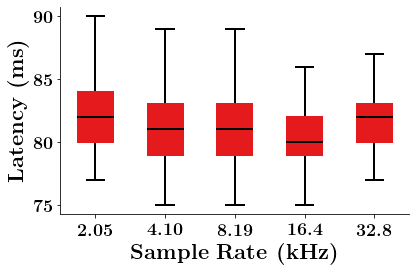

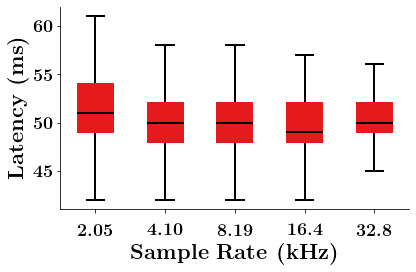

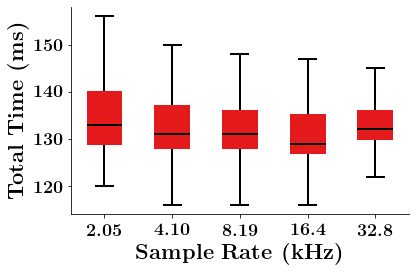

In [22]:
# box_plot_compare((latencyVals[:,1,:])/1000,vibSampleLabels,inferenceLocations,savefig=True,filename='RMS_ExtractLatency_' + modelId,
#          template='wide',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Latency (s)',
#          showfliers=True,legend_loc='upper left',max_cutoff=5,
#          log_y=False)

box_plot(latencyVals[:,0,:] - 100,vibSampleLabels,savefig=True,filename='RMS_SampleLatency_' + modelId,
         template='publication',xlabel='Sample Rate (kHz)',ylabel='Latency (ms)',color_order=np.zeros(6).astype(int),
         plot_type='box')
box_plot(latencyVals[:,1,:],vibSampleLabels,savefig=True,filename='RMS_FeatureExtractLatency_' + modelId,
         template='publication',xlabel='Sample Rate (kHz)',ylabel='Latency (ms)',xtickpad=10,color_order=np.zeros(6).astype(int))

box_plot(latencyVals[:,0,:]+latencyVals[:,1,:]-100,vibSampleLabels,savefig=True,filename='RMS_TotalLatency_' + modelId,
         template='publication',xlabel='Sample Rate (kHz)',color_order=np.zeros(6).astype(int),ylabel='Total Time (ms)')
